In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

pi = np.pi
np.random.seed(123)

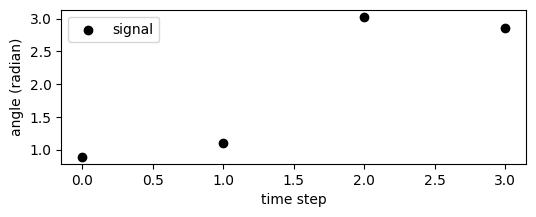

In [2]:
# create 1D angular signal
signal = np.concatenate([np.random.normal(m, 0.1, 2) for m in [1, 3]])
signal = signal.reshape((-1, 1))

# shift the signal into [0, 2pi)
signal[signal < 0]    += 2*pi
signal[signal > 2*pi] -= 2*pi

# plot signal
plt.figure(figsize=(6, 2))
plt.scatter(np.arange(len(signal)), signal, label='signal', color='black')
plt.legend(loc='best')
plt.xlabel("time step")
plt.ylabel("angle (radian)")
plt.show()

In [3]:
# discrete means set
centroids = np.linspace(1, 4, 3, endpoint = False).reshape(-1, 1)

## Define util functions

In [4]:
def get_state_sequence(costs, penalty):
    n_samples, n_states = costs.shape
    soc_array = np.empty((n_samples + 1, n_states), dtype=np.float64)
    state_array = np.empty((n_samples + 1, n_states), dtype=np.int32)
    soc_array[0] = 0
    state_array[0] = -1

    # Forward loop
    for t in range(1, n_samples + 1):
        for k_state in range(n_states):
            best_state = k_state
            best_soc = soc_array[t - 1][best_state]
            for k in range(n_states):
                if k != k_state:
                    soc = soc_array[t - 1][k]
                    if soc + penalty < best_soc:
                        best_state = k
                        best_soc = soc + penalty

            soc_array[t, k_state] = best_soc + costs[t - 1, k_state]
            state_array[t, k_state] = best_state

    # Backtracking
    end = n_samples
    state = np.argmin(soc_array[end])
    states = np.empty(n_samples, dtype=np.int32)
    while (state > -1) and (end > 0):
        states[end - 1] = state
        state = state_array[end, state]
        end -= 1
    return states, soc_array, state_array

In [5]:
@njit
def dist_func(x: np.ndarray, y: np.ndarray) -> float:
    diff = np.abs(x - y)
    return np.sum(np.fmin(diff, 2 * np.pi - diff))

@njit(parallel=True)
def compute_all_costs(signal, means):
    n_samples = signal.shape[0]
    n_states = means.shape[0]
    costs = np.empty((n_samples, n_states), dtype=np.float64)
    for k_state in range(n_states):
        for k_sample in range(n_samples):
            costs[k_sample, k_state] = dist_func(signal[k_sample], means[k_state])
    return costs

costs = compute_all_costs(signal, centroids)

C:\Users\nguye\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numba\core\typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\..\AppData\Local\Temp\ipykernel_15040\1696595820.py", line 6:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


In [6]:
costs

array([[0.10856306, 1.10856306, 2.10856306],
       [0.09973454, 0.90026546, 1.90026546],
       [2.02829785, 1.02829785, 0.02829785],
       [1.84937053, 0.84937053, 0.15062947]])

In [7]:
# 2. Perform discrete change-point detection.
penalty = 0.1
# states = get_state_sequence(costs, penalty)
states, soc_array, state_array = get_state_sequence(costs, penalty)
approx = centroids[states]

In [8]:
states

array([0, 0, 2, 2])

In [9]:
soc_array

array([[0.        , 0.        , 0.        ],
       [0.10856306, 1.10856306, 2.10856306],
       [0.2082976 , 1.10882852, 2.10882852],
       [2.23659545, 1.33659545, 0.33659545],
       [2.28596598, 1.28596598, 0.48722493]])

In [10]:
state_array

array([[-1, -1, -1],
       [ 0,  1,  2],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 2,  2,  2]])